# Data preparation

In our initial look at the data, we saw there are some NaNs, which we should take care of.
Additionaly we should consider to perhaps remove some outliers.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('vgsales.csv')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## NaNs

**Year** and **Publisher** had some NaN values. Let's take a look at those rows.

In [50]:
def assess_nans(column):
    """ Print some data regarding selected column NaN values and add an na column indicating if this column is null to the df"""
    na_col = f"{column}-na"
    df[na_col] = df[column].isna()
    sub_df = df[df[na_col]]
    sub_df.sort_values('Global_Sales')
    num_missing = len(sub_df)
    global_sales_missing = sum(sub_df['Global_Sales'])
    print(f"{num_missing} rows with {column.upper()} val missing, {num_missing/len(df)*100:.2f}% of total")
    print(f"{global_sales_missing:.0f}M in global sales for those rows ({(global_sales_missing/sum(df['Global_Sales']))*100:.2f}% of total)")
    print('some examples:')
    print(sub_df[['Name','Platform','Year','Genre','Publisher','Global_Sales']].head())
  

In [51]:
assess_nans('Year')

271 rows with YEAR val missing, 1.63% of total
100M in global sales for those rows (1.12% of total)
some examples:
                           Name Platform  Year     Genre                               Publisher  Global_Sales
179             Madden NFL 2004      PS2   NaN    Sports                         Electronic Arts          5.23
377            FIFA Soccer 2004      PS2   NaN    Sports                         Electronic Arts          3.49
431  LEGO Batman: The Videogame      Wii   NaN    Action  Warner Bros. Interactive Entertainment          3.17
470  wwe Smackdown vs. Raw 2006      PS2   NaN  Fighting                                     NaN          3.00
607              Space Invaders     2600   NaN   Shooter                                   Atari          2.53


In [52]:
assess_nans('Publisher')

58 rows with PUBLISHER val missing, 0.35% of total
15M in global sales for those rows (0.17% of total)
some examples:
                                                   Name Platform    Year     Genre Publisher  Global_Sales
470                          wwe Smackdown vs. Raw 2006      PS2     NaN  Fighting       NaN          3.00
1303                                     Triple Play 99       PS     NaN    Sports       NaN          1.46
1662       Shrek / Shrek 2 2-in-1 Gameboy Advance Video      GBA  2007.0      Misc       NaN          1.21
2222                                 Bentley's Hackpack      GBA  2005.0      Misc       NaN          0.93
3159  Nicktoons Collection: Game Boy Advance Video V...      GBA  2004.0      Misc       NaN          0.64


We see that in some cases both columns are NaN. Let's look into them:

In [49]:
na_cols = [f"{column}-na" for column in ['Year','Publisher']]
double_na = df[df[na_cols[0]]].copy()
double_na = double_na[df[na_cols[1]]].copy()
# double_na[['Name','Platform','Year','Genre','Publisher','Global_Sales']]
num_double = len(double_na)
platform_double = double_na['Platform'].value_counts()
genre_double = double_na['Genre'].value_counts()
print(f"{num_double} rows with both columns as nan")
print(f"top 3 platforms: {[(x, platform_double[x]) for x in platform_double[:3].index]}")
print(f"top 3 genres: {[(x, genre_double[x]) for x in genre_double[:3].index]}")
print(f"{sum(double_na['Global_Sales']):.2f}M global sales for rows with double nans")

22 rows with both columns as nan
top 3 platforms: [('DS', 5), ('PS', 3), ('PS3', 3)]
top 3 genres: [('Action', 5), ('Sports', 3), ('Misc', 3)]
6.49M global sales for rows with double nans


/var/folders/n4/dv38_p5d0x31c1n6tpyw2hr40000gn/T/ipykernel_2111/2520786064.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  double_na = double_na[df[na_cols[1]]].copy()


## Handling NaN values

### Both columns are NaN

As there are only 22 such rows which amount to 6.5M in global sales, we'll drop those rows.

### Year

Even though year is numeric, we will take mode and not mean, as the years are discreete values in this data. We could have taken a round mean, yet given the sales are not lineary related to time, this doesn't make sense, and mode should be preferred. Mode will fill the year column with the year in which most games were created.

However, before doing that, I notice that some games with NaN year have the year in their name. So I will first fill those and then take care of the rest.

### Publisher

We'll take mode for this.

In [79]:
# copying df 
processed = df.copy()

# dropping rows with 2 NaNs
processed.dropna(subset = ['Year','Publisher'], how='all',inplace=True, thresh=1)
print(f"{len(df) - len(processed)} rows with duplicate nans removed")

22 rows with duplicate nans removed


In [108]:
# extracting year where available
years = [str(round(x)) for x in (df['Year'].unique()) if x > 0]
def get_year_from_name(name):
    name_last_word = name.split()[-1]
    if name_last_word in years:
        return int(name_last_word)
    return None
 
processed['game_year'] = processed['Name'].apply(get_year_from_name)

#checking results
with_year_in_name = processed[processed['game_year']>0]
print(f"year found for {len(with_year_in_name)} rows")
print("correlation between year reported and year found:")
print(with_year_in_name[['Year','game_year']].corr())


year found for 658 rows
correlation between year reported and year found:
               Year  game_year
Year       1.000000   0.980346
game_year  0.980346   1.000000


In [115]:
#replace found year where missing
missing_years = processed[processed['Year-na']]
processed['Year'] = processed.apply(lambda x: x['Year'] if x['Year']>0 else x['game_year'],axis = 1)
found_years_for_missing = missing_years[processed['Year'] > 0]
print(f"Replaced value for {len(found_years_for_missing)} rows out of {len(missing_years)} which didn't have year info")


Replaced value for 14 rows out of 249 which didn't have year info


/var/folders/n4/dv38_p5d0x31c1n6tpyw2hr40000gn/T/ipykernel_2111/4128112580.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  found_years_for_missing = missing_years[processed['Year'] > 0]


In [128]:
#replace still missing values with mode
pub_m = processed['Publisher'].mode()[0] #'Electronic Arts'
year_m = processed['Year'].mode()[0] #2009
processed['Year'] = processed['Year'].apply(lambda x: x if x > 0 else year_m)
processed['Publisher'] = processed['Publisher'].apply(lambda x: pub_m if x is None else x)


processed[processed['Year-na']].head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Year-na,Publisher-na,game_year
179,180,Madden NFL 2004,PS2,2004.0,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23,True,False,2004.0
377,378,FIFA Soccer 2004,PS2,2004.0,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.49,True,False,2004.0
431,432,LEGO Batman: The Videogame,Wii,2009.0,Action,Warner Bros. Interactive Entertainment,1.86,1.02,0.00,0.29,3.17,True,False,NaN
607,608,Space Invaders,2600,2009.0,Shooter,Atari,2.36,0.14,0.00,0.03,2.53,True,False,NaN
624,625,Rock Band,X360,2009.0,Misc,Electronic Arts,1.93,0.34,0.00,0.21,2.48,True,False,NaN


/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Global_Sales'>

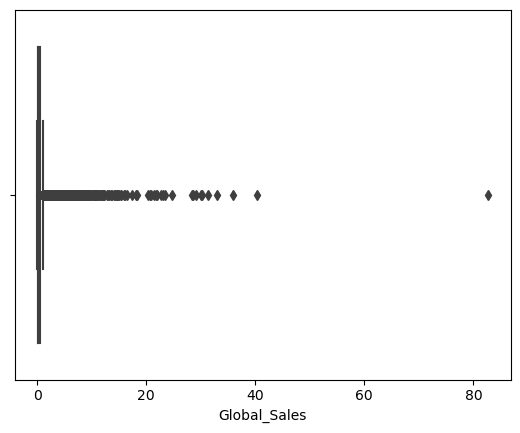

In [4]:
sns.boxplot(df['Global_Sales'])